In [1]:
import pandas as pd
import numpy as np

import math
import gc
gc.collect()


0

### Load all seasons

In [2]:
seasons = list(range(2009,2019)) # creates list of years through 2018

# merge seasons into one df
df = pd.DataFrame()
for season in seasons:
    path = './../data/nflscrapR-data/play_by_play_data/regular_season/reg_pbp_'+str(season)+'.csv'
    season_df = pd.read_csv(path)
    season_df['season'] = season
    df = pd.concat([df, season_df], axis=0)
#     path = './../data/nflscrapR-data/play_by_play_data/post_season/post_pbp_'+str(season)+'.csv'
#     post_season_df = pd.read_csv(path)
#     post_season_df['season'] = season
#     df = pd.concat([df, post_season_df], axis=0)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (42,166,167,174,175,178,179,182,183,188,189,190,191,203,204,205,231,232,233,238,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (37,38,39,42,46,47,166,167,168,169,172,173,174,175,176,177,178,179,182,183,184,185,188,189,190,191,192,193,194,195,198,199,203,204,205,224,225,226,227,231,232,233,238,240,241,244,245,246,250) have mixed types. Speci

### Data Preprocessing

In [3]:
print(len(df))

# standardize jaguars abbrev
df['posteam']=df['posteam'].replace('JAC','JAX')

# drop redzone plays & inside own 5
df = df.loc[(df.yardline_100 > 20) & (df.yardline_100 < 95)]

# drop extreme win probabilities (about 4% of plays)
df = df.loc[(df['wp']>=0.05) | (df['wp']<=0.95)]

# drop afc and nfc

conf_teams = ['AFC','NFC','IRV','APR','NPR','RIC','SANS']
df = df.loc[~df['posteam'].isin(conf_teams)]
print(len(df))



452661
362283


### Load Roster Data

found here: https://github.com/btatkinson/pfr_scraper

In [4]:
path = './../data/roster/roster_info.csv'
roster = pd.read_csv(path)
roster['sea_id'] = roster['season'].astype(str)+roster['player_id']

roster = roster[['id','player_id','season','pos','sea_id','name','age','height','weight','av']]

roster.head(5)

,id,player_id,season,pos,sea_id,name,age,height,weight,av
0,2009PITB.Roethlisberger,00-0022924,2009,QB,200900-0022924,Ben Roethlisberger,27.0,77.0,240.0,14.0
1,2009TENK.Collins,00-0003292,2009,QB,200900-0003292,Kerry Collins,37.0,77.0,247.0,2.0
2,2009CLEB.Quinn,00-0025409,2009,QB,200900-0025409,Brady Quinn,25.0,76.0,232.0,2.0
3,2009MINB.Favre,00-0005106,2009,QB,200900-0005106,Brett Favre,40.0,74.0,222.0,16.0
4,2009NOD.Brees,00-0020531,2009,QB,200900-0020531,Drew Brees,30.0,72.0,209.0,16.0


### QB heatmap

In [5]:
qbs = df.copy()

# drop unnecessary columns
qbs = qbs.drop(columns=['assist_tackle', 'assist_tackle_1_player_id', 'assist_tackle_1_player_name', 'assist_tackle_1_team', 'assist_tackle_2_player_id', 'assist_tackle_2_player_name', 'assist_tackle_2_team', 'assist_tackle_3_player_id', 'assist_tackle_3_player_name', 'assist_tackle_3_team', 'assist_tackle_4_player_id', 'assist_tackle_4_player_name', 'assist_tackle_4_team',
                       'kick_distance', 'kicker_player_id', 'kicker_player_name', 'kickoff_attempt', 'kickoff_downed', 'kickoff_fair_catch', 'kickoff_in_endzone', 'kickoff_inside_twenty', 'kickoff_out_of_bounds', 'kickoff_returner_player_id', 'kickoff_returner_player_name', 'lateral_interception_player_id', 'lateral_interception_player_name', 'lateral_kickoff_returner_player_id', 
                        'lateral_kickoff_returner_player_name', 'lateral_punt_returner_player_id', 'lateral_punt_returner_player_name', 'lateral_receiver_player_id', 'lateral_receiver_player_name', 'lateral_reception', 'lateral_recovery', 'lateral_return', 'lateral_rush', 'lateral_rusher_player_id', 'lateral_rusher_player_name', 'lateral_sack_player_id', 'lateral_sack_player_name',
                         'own_kickoff_recovery','own_kickoff_recovery_player_id','own_kickoff_recovery_player_name','own_kickoff_recovery_td','solo_tackle', 'solo_tackle_1_player_id', 'solo_tackle_1_player_name', 'solo_tackle_1_team', 'solo_tackle_2_player_id', 'solo_tackle_2_player_name', 'solo_tackle_2_team','punt_attempt', 'punt_blocked', 'punt_downed', 'punt_fair_catch', 'punt_in_endzone', 
                        'punt_inside_twenty', 'punt_out_of_bounds', 'punt_returner_player_id', 'punt_returner_player_name', 'punter_player_id', 'punter_player_name','total_away_comp_air_epa', 'total_away_comp_air_wpa', 'total_away_comp_yac_epa', 'total_away_comp_yac_wpa', 'total_away_epa', 'total_away_pass_epa', 'total_away_pass_wpa', 'total_away_raw_air_epa', 'total_away_raw_air_wpa', 'total_away_raw_yac_epa', 
                        'total_away_raw_yac_wpa', 'total_away_rush_epa', 'total_away_rush_wpa', 'total_away_score', 'total_home_comp_air_epa', 'total_home_comp_air_wpa', 'total_home_comp_yac_epa', 'total_home_comp_yac_wpa', 'total_home_epa', 'total_home_pass_epa', 'total_home_pass_wpa', 'total_home_raw_air_epa', 'total_home_raw_air_wpa', 'total_home_raw_yac_epa', 'total_home_raw_yac_wpa', 'total_home_rush_epa', 
                        'total_home_rush_wpa', 'total_home_score', 'touchback', 'two_point_attempt', 'two_point_conv_result'])

qb_ids = roster.loc[roster.pos=='QB']
qb_ids = list(qb_ids.player_id.values)

print(len(qbs))
qbs = qbs.loc[(qbs['passer_player_id'].isin(qb_ids)) | qbs['rusher_player_id'].isin(qb_ids)]
print(len(qbs))


qbs['season'] = qbs['season'].astype(str)

qb_rushes = qbs.loc[qbs.play_type=='run']
qb_passes = qbs.loc[qbs.play_type=='pass']

qb_rushes['id'] = qb_rushes['season'] + qb_rushes['posteam'] + qb_rushes['rusher_player_name']
qb_passes['id'] = qb_passes['season'] + qb_passes['posteam'] + qb_passes['passer_player_name']


qb_rushes = pd.merge(how='left',left=qb_rushes,right=roster,on=['id'])
qb_passes = pd.merge(how='left',left=qb_passes,right=roster,on=['id'])


print(qb_rushes.shape)
print(qb_passes.shape)

qb_rushes = qb_rushes.drop(columns=['season_y'])
qb_passes = qb_passes.drop(columns=['season_y'])

qb_rushes = qb_rushes.rename(columns={'season_x':'season'})
qb_passes = qb_passes.rename(columns={'season_x':'season'})




362283
175442


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(9731, 174)
(161204, 174)


In [6]:
# only take QBs that matched roster ids. About 94% of pass plays
qb_passes = qb_passes.loc[qb_passes['player_id']==qb_passes['passer_player_id']]
qb_rushes = qb_rushes.loc[qb_rushes['player_id']==qb_rushes['rusher_player_id']]
print(qb_passes.shape)
print(qb_rushes.shape)

(151749, 173)
(9250, 173)


In [7]:
qb_passes['sea_id'] = qb_passes['season'].astype(str) + qb_passes['passer_player_id']
qb_rushes['sea_id'] = qb_rushes['season'].astype(str) + qb_rushes['rusher_player_id']

In [8]:
# only take qbs with at least 3 rushes and 100 passes
gb = qb_rushes.groupby(['id'])['epa'].count()
gb = gb.loc[gb >= 3].reset_index()
run_ids = list(gb['id'].unique())

gb = qb_passes.groupby(['id'])['epa'].count()
gb = gb.loc[gb >= 100].reset_index()
pass_ids = list(gb['id'].unique())

# get game count
gc = qb_passes.groupby(['id'])['game_id'].nunique()

# only use qbs with over 5 games
gc = gc.loc[gc > 5]
gc = gc.reset_index()
enough_games = list(gc.id.values)

qb_ids = []
for pid in pass_ids:
    if pid in run_ids:
        if pid in enough_games:
            qb_ids.append(pid)

qb_passes = qb_passes.loc[qb_passes['id'].isin(qb_ids)]
qb_rushes = qb_rushes.loc[qb_rushes['id'].isin(qb_ids)]

gc = gc.loc[gc['id'].isin(qb_ids)]

print(str(len(set(qb_ids))) + " Quarterbacks meet the criteria")

359 Quarterbacks meet the criteria


In [9]:
def explosiveness(x):
    # (Warning: O(n**2) in time and memory, where n = len(x).  *Don't* pass in huge samples!)
    
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    mean = np.mean(x)
    
    if mean == 0:
        return 0
    rmad = mad/mean
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [10]:
# brandon weeden has a play in 2013 with a nan value lol which messed shit up
print(len(qb_rushes))
qb_rushes = qb_rushes.dropna(subset=['yards_gained','wpa'])
print(len(qb_rushes))

# yards per rush
ypc = qb_rushes.groupby(['id'])['yards_gained'].mean().reset_index()
ypc = ypc.rename(columns={'yards_gained':'YPC'})

# win probability added on rushes (will do per game later)
wpa = qb_rushes.groupby(['id'])['wpa'].sum().reset_index()

# attempts (will do per game later)
att = qb_rushes.groupby(['id'])['yards_gained'].count().reset_index()
att = att.rename(columns={'yards_gained':'Att'})

# run explosiveness
rexp = qb_rushes.groupby(['id'])['yards_gained'].apply(explosiveness).reset_index()
rexp = rexp.rename(columns={'yards_gained':'Run_Exp'})

8472
8440


In [11]:
# merge in rushing stats
qb_run_dfs = [ypc,wpa,att,rexp]
for rdf in qb_run_dfs:
    gc = pd.merge(how='left',left=gc,right=rdf,on=['id'])

In [12]:
gc['Run Att/G'] = gc['Att']/gc['game_id']
gc['Run WPA/G'] = gc['wpa']/gc['game_id']

gc = gc.drop(columns=['Att','wpa'])

In [13]:
# check for more nans
gc1 = gc[gc.isna().any(axis=1)]
print(gc1)

Empty DataFrame
Columns: [id, game_id, YPC, Run_Exp, Run Att/G, Run WPA/G]
Index: []


In [14]:
def is_success(epa):
    return 1 if epa >= 0 else 0

# add success column
qb_passes['success'] = qb_passes.apply(lambda row: is_success(row['epa']),axis=1)

In [15]:
# total dropbacks
dbs = qb_passes.groupby(['id'])['epa'].count().reset_index()
dbs = dbs.rename(columns={'epa':'dropbacks'})


# average columns to get per dropback numbers
means = qb_passes.groupby(['id'])['touchdown','interception','complete_pass','qb_hit','sack','success','epa','wp'].mean().reset_index()

means = means.rename(columns={'touchdown':'TD/D','interception':'INT/D','complete_pass':'Comp/D','qb_hit':'Hit/D',
                              'sack':'Sack/D','success':'SR/D','epa':'EPA/D','wp':'Avg_WP'})

means['Incomp/D'] = 1-means['TD/D'] - means['INT/D'] - means['Comp/D'] - means['Sack/D']

means.tail(15)



,id,TD/D,INT/D,Comp/D,Hit/D,Sack/D,SR/D,EPA/D,Avg_WP,Incomp/D
344,2018MIAR.Tannehill,0.039568,0.025180,0.582734,0.244604,0.122302,0.420863,-0.172959,0.424242,0.230216
345,2018MINK.Cousins,0.026978,0.017986,0.669065,0.143885,0.059353,0.478417,-0.030912,0.413032,0.226619
346,2018NET.Brady,0.022403,0.018330,0.657841,0.097760,0.032587,0.511202,0.155153,0.572875,0.268839
347,2018NOD.Brees,0.024510,0.012255,0.720588,0.095588,0.036765,0.568627,0.268758,0.562731,0.205882
348,2018NYGE.Manning,0.005671,0.017013,0.635161,0.151229,0.081285,0.436673,0.026493,0.402292,0.260870
349,2018NYJS.Darnold,0.025773,0.033505,0.548969,0.105670,0.067010,0.430412,-0.098381,0.364196,0.324742
350,2018OAKD.Carr,0.013359,0.013359,0.645038,0.148855,0.091603,0.492366,-0.014665,0.351922,0.236641
351,2018PHIC.Wentz,0.010899,0.016349,0.664850,0.174387,0.073569,0.509537,0.090963,0.477000,0.234332
352,2018PITB.Roethlisberger,0.021812,0.018456,0.664430,0.095638,0.038591,0.503356,0.149350,0.514624,0.256711
353,2018SEAR.Wilson,0.032995,0.012690,0.614213,0.185279,0.109137,0.451777,0.081658,0.484780,0.230964


In [16]:
# divide into completions and incompletions and sacks
qb_comps = qb_passes.loc[qb_passes.complete_pass==1]
qb_incomps = qb_passes.loc[(qb_passes.complete_pass==0) & (qb_passes.sack==0)]
qb_sacks = qb_passes.loc[(qb_passes.complete_pass==0) & (qb_passes.sack==1)]

print(len(qb_comps))
qb_comps = qb_comps.dropna(subset=['yards_after_catch'])
print(len(qb_comps))

pass_avgs = qb_comps.groupby(['id'])['yards_gained','yards_after_catch','air_yards'].mean().reset_index()
pass_avgs = pass_avgs.rename(columns={'yards_gained':'YPComp','yards_after_catch':'YAC','air_yards':'aDOT'})


### SOME QBS HAVE NaNs on completions
# jd = qb_comps.loc[qb_comps['id']=='2009CARJ.Delhomme']
# print(len(jd))
# jd = jd.dropna(subset=['yards_after_catch'])
# print(len(jd))

# have to calc expl separately
expl_compl = qb_comps.groupby(['id'])['yards_gained'].apply(explosiveness).reset_index()
expl_yac = qb_comps.groupby(['id'])['yards_after_catch'].apply(explosiveness).reset_index()
expl_ay = qb_comps.groupby(['id'])['air_yards'].apply(explosiveness).reset_index()

expl_compl = expl_compl.rename(columns={'yards_gained':'YPComp_Expl'})
expl_yac = expl_yac.rename(columns={'yards_after_catch':'YAC_Expl'})
expl_ay = expl_ay.rename(columns={'air_yards':'AY_Expl'})

icay = qb_incomps.groupby(['id'])['air_yards'].mean().reset_index()
icay = icay.rename(columns={'air_yards':'ICAY'})


83388
83274


In [17]:
# merge in pass dataframes
qb_pass_dfs = [dbs,means,pass_avgs,expl_compl,expl_yac,expl_ay,icay]
for pdf in qb_pass_dfs:
    gc = pd.merge(how='left',left=gc,right=pdf,on=['id'])

gc['Dropbacks/G'] = gc['dropbacks']/gc['game_id']

# check for more nans
gc1 = gc[gc.isna().any(axis=1)]
print(gc1)
gc = gc.drop(columns=['game_id','dropbacks'])
gc.head()

Empty DataFrame
Columns: [id, game_id, YPC, Run_Exp, Run Att/G, Run WPA/G, dropbacks, TD/D, INT/D, Comp/D, Hit/D, Sack/D, SR/D, EPA/D, Avg_WP, Incomp/D, YPComp, YAC, aDOT, YPComp_Expl, YAC_Expl, AY_Expl, ICAY, Dropbacks/G]
Index: []

[0 rows x 24 columns]


,id,YPC,Run_Exp,Run Att/G,Run WPA/G,TD/D,INT/D,Comp/D,Hit/D,Sack/D,...,Avg_WP,Incomp/D,YPComp,YAC,aDOT,YPComp_Expl,YAC_Expl,AY_Expl,ICAY,Dropbacks/G
0,2009ARIK.Warner,1.666667,1.266667,0.40,-0.012952,0.013187,0.026374,0.639560,0.136264,0.050549,...,0.533069,0.270330,11.656357,4.962199,6.694158,0.357830,0.557648,0.592653,11.198582,30.266667
1,2009ATLM.Ryan,3.714286,0.291209,1.00,0.001609,0.020202,0.027778,0.583333,0.085859,0.035354,...,0.507584,0.333333,11.515152,4.787879,6.727273,0.391554,0.653515,0.569562,11.900662,28.285714
2,2009BALJ.Flacco,2.800000,0.585714,1.25,-0.000715,0.016913,0.014799,0.602537,0.122622,0.073996,...,0.493046,0.291755,11.807018,5.547368,6.259649,0.414846,0.640376,0.761097,13.692810,29.500000
3,2009BUFR.Fitzpatrick,5.615385,0.444152,2.60,0.039420,0.023364,0.037383,0.514019,0.210280,0.098131,...,0.461410,0.327103,11.072727,5.354545,5.718182,0.445052,0.645918,0.834702,13.867470,21.400000
4,2009BUFT.Edwards,9.100000,0.451648,1.25,0.025693,0.016393,0.027322,0.546448,0.245902,0.120219,...,0.440119,0.289617,11.240000,5.080000,5.930000,0.449786,0.590276,0.741298,9.278689,22.625000


In [18]:
# merge in roster
roster_merge = roster[['id','sea_id','age','height','weight','av']]
gc = pd.merge(how='left',left=gc,right=roster_merge,on=['id'])


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# change gc column order
print(len(list(gc)))
cols = ['sea_id','age','height','weight','av',
        'Dropbacks/G','EPA/D','SR/D','Comp/D','Incomp/D','TD/D','INT/D','Sack/D','Hit/D','Avg_WP',
        'YPComp','aDOT','YAC','YPComp_Expl','YAC_Expl','AY_Expl','ICAY','YPC','Run_Exp','Run Att/G',
        'Run WPA/G']
gc = gc[cols]
print(len(list(gc)))

fig, ax = plt.subplots(figsize=(16, 11))

#saleprice correlation matrix
sns.heatmap(gc.corr(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':10},
            cbar=True,
            square=False)

plt.show()

fig.savefig('./plots/QB_Heatmap.png', bbox_inches='tight')

27
26


<Figure size 1600x1100 with 2 Axes>

### PCA!

In [20]:
# follows https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

# drop nans (32 QBs) - not sure what's wrong, but most are from '09/10 and I'm okay with excluding them
print(len(gc))
gc = gc.dropna()
print(len(gc))

# drop duplicates - not sure how these got here
print(len(gc))
gc = gc.drop_duplicates(subset='sea_id')
print(len(gc))

from sklearn.preprocessing import StandardScaler

features = cols[1:]
labels = cols[:1]

# Separating out the features
x = gc.loc[:, features].values
labels = gc.loc[:,labels]


roster_names = roster[['sea_id','age','season','name']]
roster_names = roster_names.drop_duplicates()

labels = pd.merge(how='left',left=labels, right=roster_names, on=['sea_id'])

labels['label'] = labels['season'].astype(str) + '_' + labels['name']

# Standardizing the features
x = StandardScaler().fit_transform(x)

359
359
359
359


In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

pca_df = pd.concat([labels,pca_df],axis=1)

# lead_pc1 = ['2011_Aaron Rodgers','2011_Drew Brees']
# lead_pc2 = ['2013_Michael Vick', '2017_Deshaun Watson']
# lead_pc3 = ['2014_Robert Griffin','2017_Drew Brees']

pca_df = pca_df.sort_values(by='pc1',ascending=True).reset_index()

# ar11 = pca_df[pca_df['label']=='2011_Aaron Rodgers'].index.values.astype(int)[0]
# db11 = pca_df[pca_df['label']=='2011_Drew Brees'].index.values.astype(int)[0]
# mv13 = pca_df[pca_df['label']=='2013_Michael Vick'].index.values.astype(int)[0]
# dw17 = pca_df[pca_df['label']=='2017_Deshaun Watson'].index.values.astype(int)[0]
# rg14 = pca_df[pca_df['label']=='2014_Robert Griffin'].index.values.astype(int)[0]
# db17 = pca_df[pca_df['label']=='2017_Drew Brees'].index.values.astype(int)[0]

# print([ar11,db11,mv13,dw17,rg14,db17])

pca_df.head(5)

,index,sea_id,age,season,name,label,pc1,pc2,pc3
0,86,201100-0023459,28.0,2011,Aaron Rodgers,2011_Aaron Rodgers,-5.784899,2.730552,0.447076
1,97,201100-0020531,32.0,2011,Drew Brees,2011_Drew Brees,-5.747849,-0.890111,-1.049146
2,254,201600-0026143,31.0,2016,Matt Ryan,2016_Matt Ryan,-5.450330,1.799079,0.703415
3,156,201300-0010346,37.0,2013,Peyton Manning,2013_Peyton Manning,-5.415779,-2.507211,1.346885
4,347,201800-0020531,39.0,2018,Drew Brees,2018_Drew Brees,-5.373051,-1.205044,-0.894229


### Plot in 3d

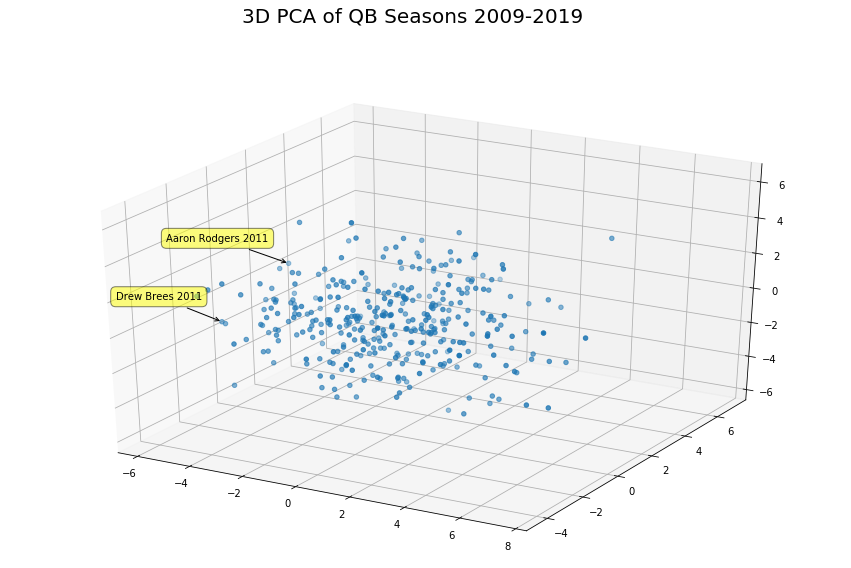

In [22]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = pylab.figure(figsize=(15,9))
ax = fig.add_subplot(111, projection = '3d')

x = pca_df.pc1
y = pca_df.pc2
z = pca_df.pc3

sc = ax.scatter(x,y,z)
# now try to get the display coordinates of the first point

x1, y1, _1 = proj3d.proj_transform(-5.747849,-0.890111,-1.049146, ax.get_proj())
x2, y2, _2 = proj3d.proj_transform(-5.784899, 2.730552,0.447076, ax.get_proj())

label1 = pylab.annotate(
    "Drew Brees 2011", 
    xy = (x1, y1), xytext = (-20, 20),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

label2 = pylab.annotate(
    "Aaron Rodgers 2011", 
    xy = (x2, y2), xytext = (-20, 20),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))


def update_position1(e):
    x1, y1, _1 = proj3d.proj_transform(1,1,1, ax.get_proj())
    label1.xy = x1,y1
    label1.update_positions(fig.canvas.renderer)
    
def update_position2(e):
    x2, y2, _2 = proj3d.proj_transform(1,1,1, ax.get_proj())
    label2.xy = x2,y2
    label2.update_positions(fig.canvas.renderer)
    fig.canvas.draw()

fig.canvas.mpl_connect('button_release_event', update_position1)
fig.canvas.mpl_connect('button_release_event', update_position2)

fig.suptitle("3D PCA of QB Seasons 2009-2019", fontsize=20)

pylab.show()

fig.savefig('./plots/QB_3D.png', bbox_inches='tight')

### 2D is better...

In [23]:
x = gc.loc[:, features].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

pca_df = pd.concat([labels,pca_df],axis=1)

pca_df.head(5)

,sea_id,age,season,name,label,pc1,pc2
0,200900-0017200,38.0,2009,Kurt Warner,2009_Kurt Warner,-1.749941,-2.582098
1,200900-0026143,24.0,2009,Matt Ryan,2009_Matt Ryan,-0.159449,-1.106449
2,200900-0026158,24.0,2009,Joe Flacco,2009_Joe Flacco,-0.596089,-0.805504
3,200900-0023682,27.0,2009,Ryan Fitzpatrick,2009_Ryan Fitzpatrick,4.151497,1.651135
4,200900-0025479,26.0,2009,Trent Edwards,2009_Trent Edwards,4.049061,0.897107


(359,)
(359, 2)


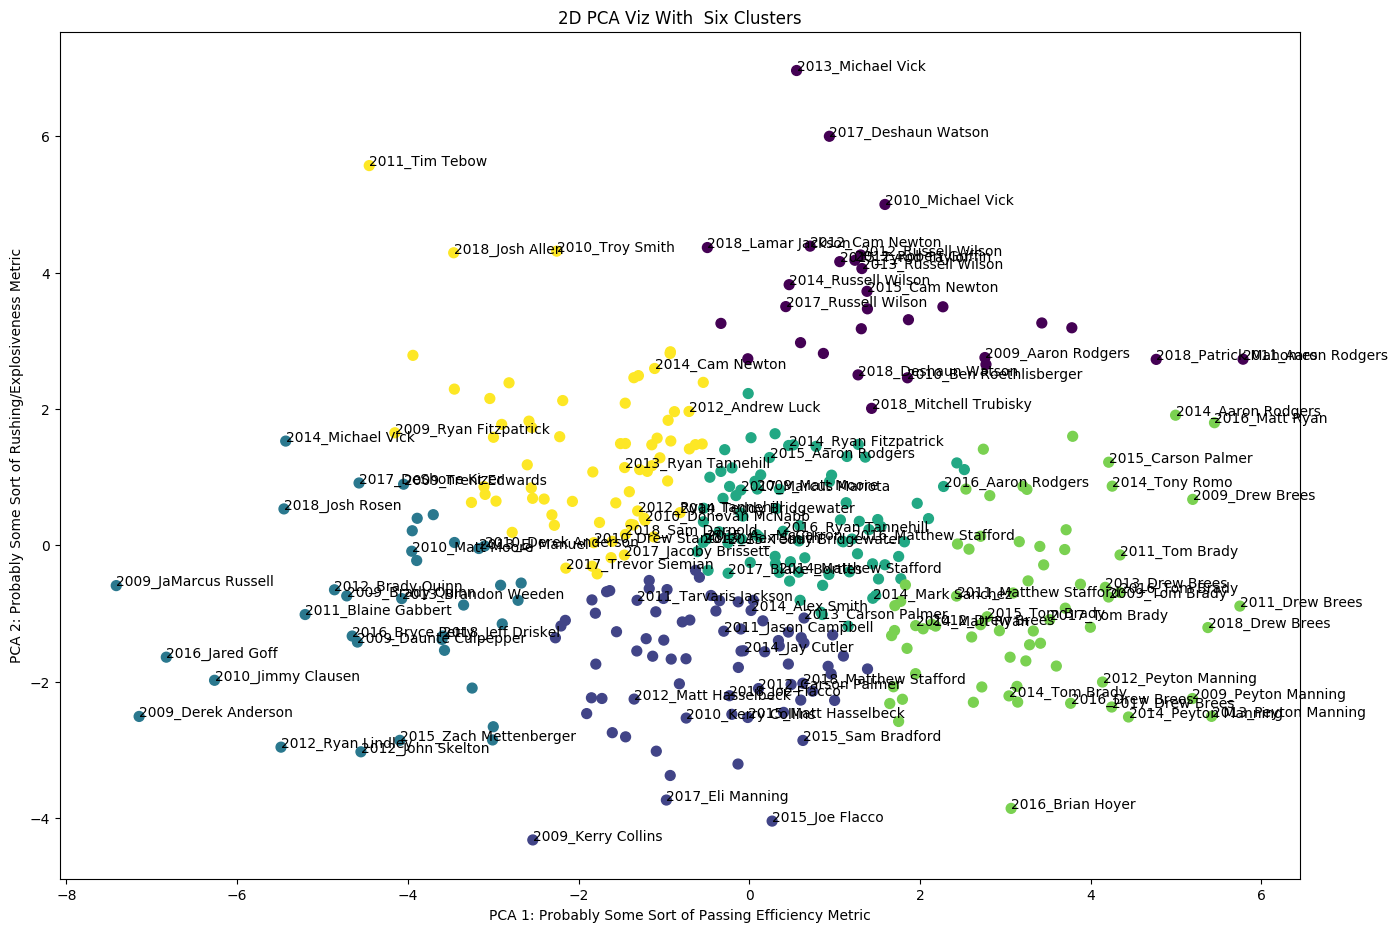

In [24]:
from sklearn.cluster import KMeans,DBSCAN
import random

plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots(figsize=(16, 11))

# i like better to be positive
if (pca_df.loc[pca_df['label']=='2011_Aaron Rodgers'].pc1.values[0] <1):
    pca_df['pc1'] = pca_df['pc1'] * -1

X = pca_df[['pc1','pc2']].values

x = pca_df.pc1.values
y = pca_df.pc2.values
n = pca_df.label.values

# clusters = DBSCAN(eps=0.6, min_samples=5).fit_predict(X)
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
clusters = kmeans.predict(X)
print(clusters.shape)

print(X.shape)
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')

for i, txt in enumerate(n):
    if ((x[i] >= 4) | (x[i] <=-4)):
        ax.annotate(txt, (x[i], y[i]))
    elif ((y[i] >= 3.5) | (y[i] <= -3.5)):
        ax.annotate(txt, (x[i], y[i]))
    # label some randoms in the middle
    elif ((x[i] <= 4) & (x[i] >=-4) & (y[i] <= 3.5) & (y[i] >= -3.5)):
        if random.random() < 0.15:
            ax.annotate(txt, (x[i], y[i]))
        
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
pca_df['cluster'] = clusters

ax.set_title('2D PCA Viz With  Six Clusters')
ax.set_xlabel('PCA 1: Probably Some Sort of Passing Efficiency Metric')
ax.set_ylabel('PCA 2: Probably Some Sort of Rushing/Explosiveness Metric')

fig.savefig('./plots/QB_2D.png', bbox_inches='tight')

In [25]:
print(pca_df.loc[pca_df['name']=='Jared Goff'])

             sea_id   age  season        name            label       pc1  \
271  201600-0033106  22.0    2016  Jared Goff  2016_Jared Goff -6.828999   
306  201700-0033106  23.0    2017  Jared Goff  2017_Jared Goff  1.505271   
342  201800-0033106  24.0    2018  Jared Goff  2018_Jared Goff  3.253071   

          pc2  cluster  
271 -1.639257        2  
306  0.378677        3  
342  0.821448        4  


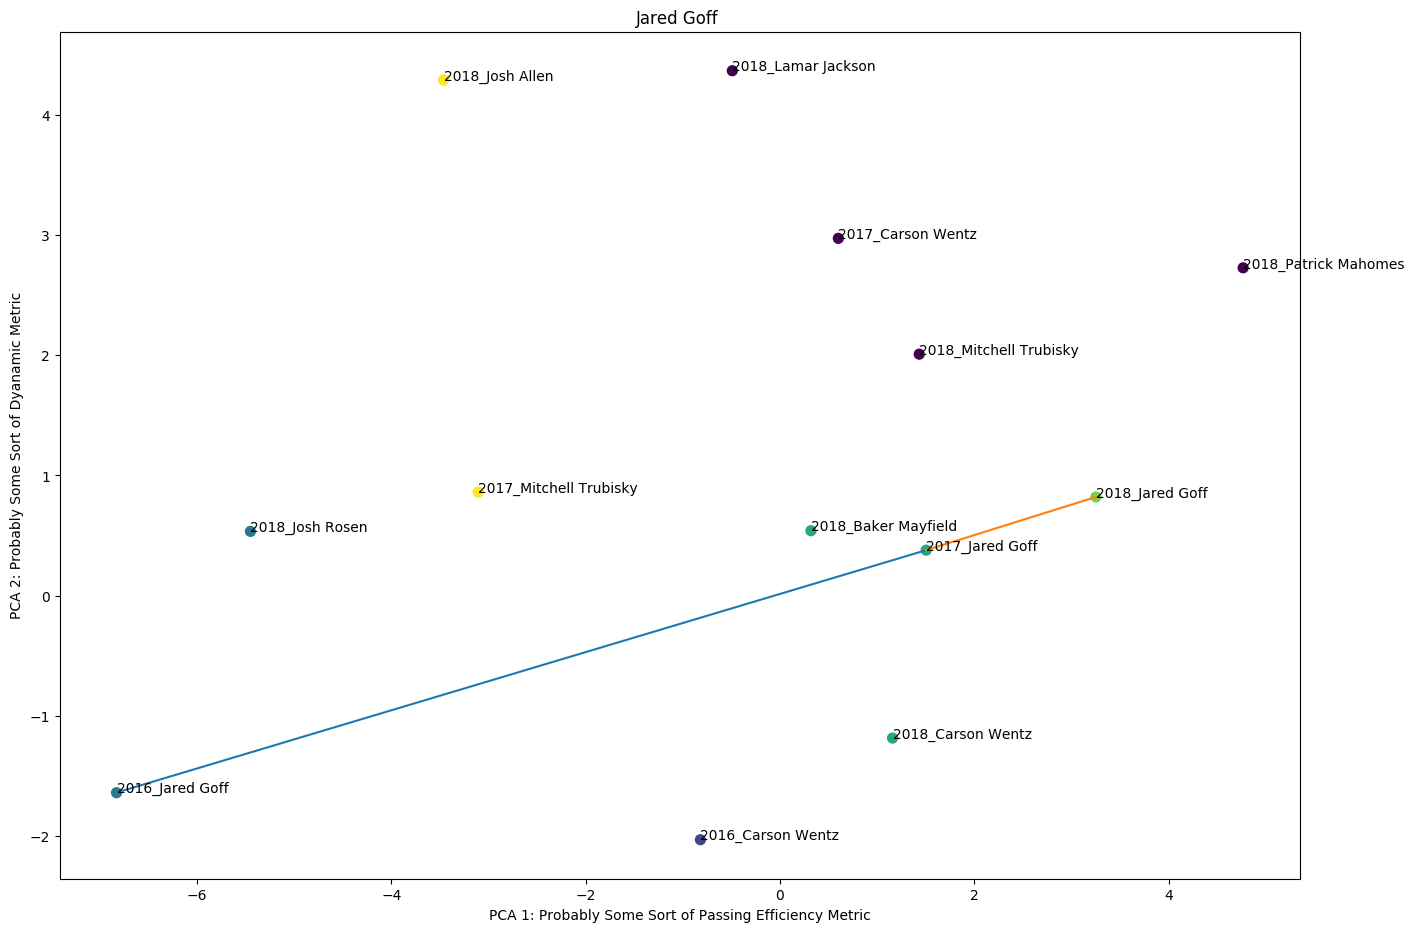

In [26]:
plt.rcParams.update(plt.rcParamsDefault)


fig, ax = plt.subplots(figsize=(16, 11))

# i like better to be positive
if (pca_df.loc[pca_df['label']=='2011_Aaron Rodgers'].pc1.values[0] <1):
    pca_df['pc1'] = pca_df['pc1'] * -1


reference_qbs = ['Josh Allen','Josh Rosen','Lamar Jackson','Carson Wentz','Mitchell Trubisky', 'Patrick Mahomes', 'Baker Mayfield', 'Mitch Trubisky']
jg_df = pca_df.loc[(pca_df['name']=='Jared Goff') | (pca_df['name'].isin(reference_qbs))]

jg_X = jg_df[['pc1','pc2']].values

jg_x = jg_df.pc1.values
jg_y = jg_df.pc2.values
jg_n = jg_df.label.values

# clusters = DBSCAN(eps=0.6, min_samples=5).fit_predict(X)
# kmeans = KMeans(n_clusters=6)
# kmeans.fit(X)
# clusters = kmeans.predict(X)

# print(X.shape)
plt.scatter(jg_X[:, 0], jg_X[:, 1], c=jg_df.cluster, s=50, cmap='viridis')

plt.plot((-6.83289,1.505),(-1.639,0.37868))
plt.plot((1.505,3.253),(0.37868,0.821448))

for i, txt in enumerate(jg_n):
    ax.annotate(txt, (jg_x[i], jg_y[i]))

ax.set_title('Jared Goff ')
ax.set_xlabel('PCA 1: Probably Some Sort of Passing Efficiency Metric')
ax.set_ylabel('PCA 2: Probably Some Sort of Dyanamic Metric')

fig.savefig('./plots/JG_2D.png', bbox_inches='tight')
plt.show()

In [27]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.animation as animation
from matplotlib import colors

def build_first_plot(df):
    
    clusters = list(df.color.values)
    name_list = list(df.label.values)
    x = df['pc1']
    y = df['pc2']

    fig, ax = plt.subplots(figsize=(15,9))
    ax.scatter(x, y, s=50,c=clusters)
    ax.set_title('PC1 vs. PC2',{"fontsize":24})
    plt.title('data from nflscrapR',fontsize=16)
    plt.suptitle('QB PCA Over Time',fontsize=24, y=0.945)
    ax.set_xlabel('PC1',{"fontsize":18})
    ax.set_ylabel('PC2',{"fontsize":18})

    for x0, y0, name in zip(x, y, name_list):
        ax.annotate(name, (x0, y0))

#BUILD THE ANIMATION, THIS WILL SAVE IT TO A MP4 FILE IN YOUR CURRENT DIRECTORY
def build_animation(df):
    x = [[] for i in range(10)]
    for i,j in zip(range(10), range(2009,2019)):
        x[i].append(df[df['season']==j]['pc1'].values.tolist())
        
    y = [[] for i in range(10)]
    for i,j in zip(range(10), range(2009,2019)):
        y[i].append(df[df['season']==j]['pc2'].values.tolist())

    seasons = list(range(2009,2019))

    #DRAW THE FIGURE FIRST
    fig, ax = plt.subplots(figsize=(15,9))
    ax.set_title('PC1 vs. PC2',{"fontsize":24})
    plt.title('data from nflscrapR',fontsize=16)
    plt.suptitle('QB PCA Over Time',fontsize=24, y=0.945)
    ax.set_xlabel('PC1',{"fontsize":18})
    ax.set_ylabel('PC2',{"fontsize":18})

    #ANIMATE OVER THE YEARS
    def animate(i):
        ax.clear()
        plt.xlim(-8,6.5)
        plt.ylim(-4.5,6.5)
        
        season = df.loc[df.season==(2009+i)]
        clusters = list(season.color.values)
        name_list = list(season.label.values)
        
        cmap = colors.ListedColormap(['g','b','y','r','k'])

        x_scatter = x[i][0]
        y_scatter = y[i][0]

        #fig, ax = plt.subplots(figsize=(10,10))
        ax.scatter(x_scatter, y_scatter, s=50, c=clusters, cmap=cmap)
        #ax.set_title('Success Rate vs. EPA/Play',{"fontsize":24})
        plt.title('data from nflscrapR',fontsize=16)
        ax.set_xlabel('PC1',{"fontsize":18})
        ax.set_ylabel('PC2',{"fontsize":18})
        ax.text(-6,-2, str(seasons[i]) + '-' + str(seasons[i]+1) + ' Season', fontsize=14)

        for x0, y0, name in zip(x_scatter, y_scatter, name_list):
            ax.annotate(name, (x0, y0))
            
    ani = animation.FuncAnimation(fig, animate, frames=10, interval=5000)
    #plt.show()

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=1, metadata=dict(artist='Blake'), bitrate=1800)
    ani.save('./plots/animated_scatter.mp4', writer=writer)
    
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


                    label  season       pc1       pc2  color
3   2009_Ryan Fitzpatrick    2009 -4.151497  1.651135      0
15     2009_Aaron Rodgers    2009  2.761151  2.754480      2
22         2009_Tom Brady    2009  4.209743 -0.757233      3
23        2009_Drew Brees    2009  5.195368  0.674732      4
24       2009_Eli Manning    2009  1.543609  0.276009      1


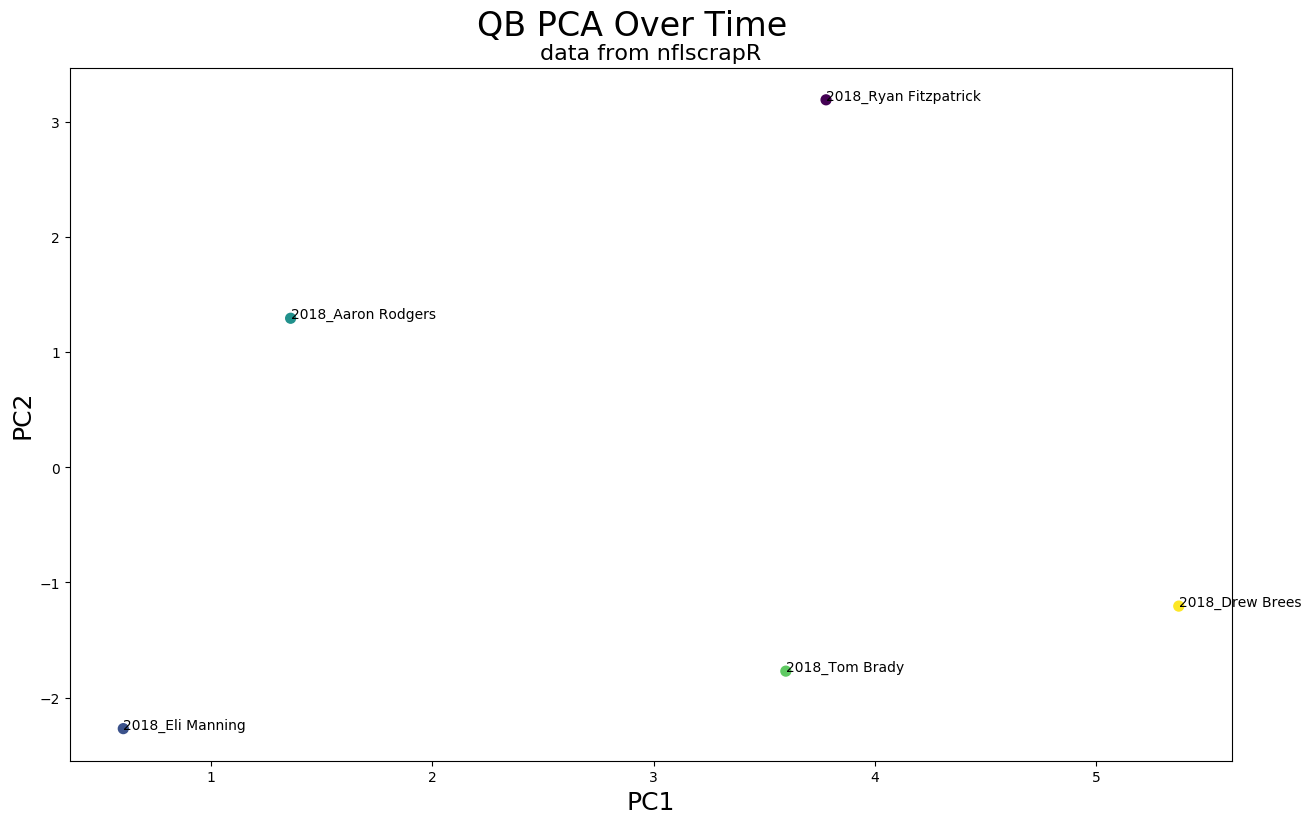

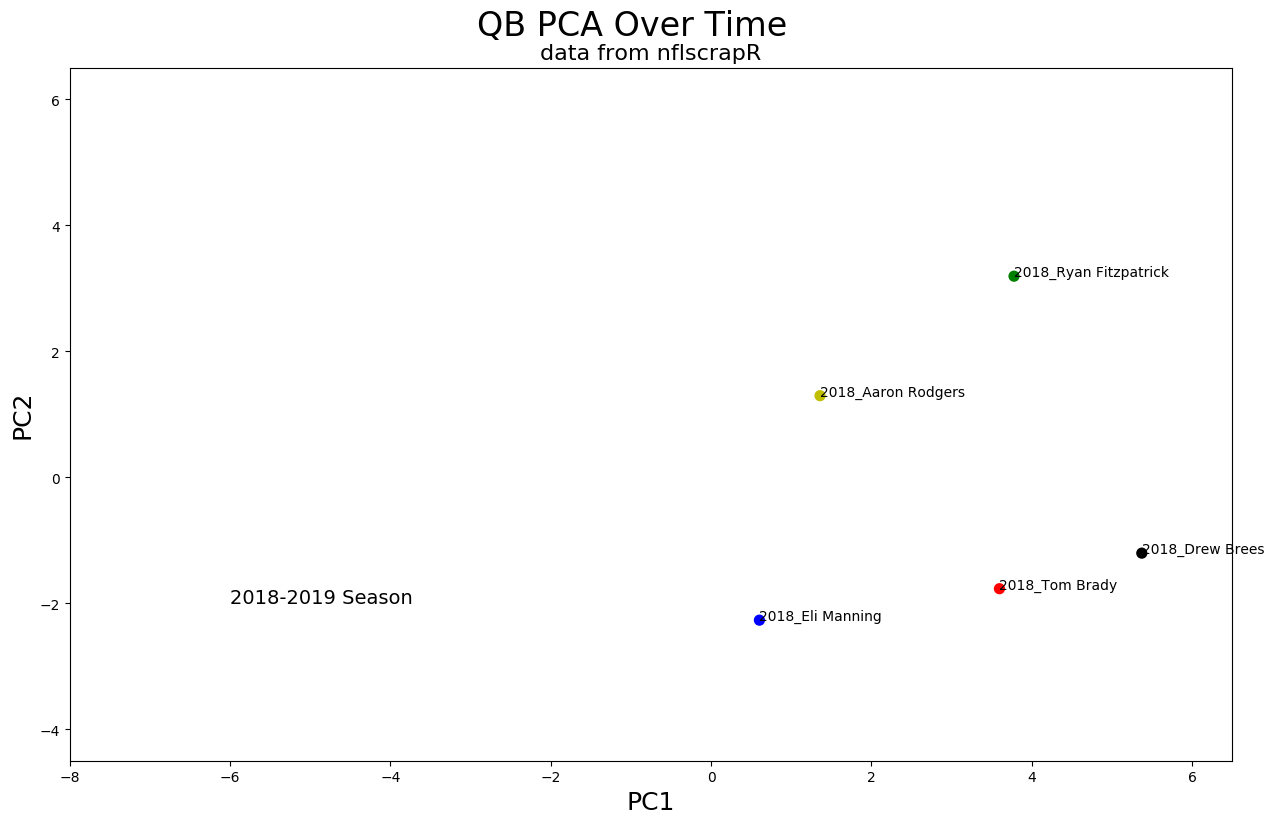

In [28]:
# some hand edits to the list 
# names18 = list(pca_df.loc[pca_df['season']==2018].name.unique())
# names18.append('Jimmy Garoppolo')
# names18.remove('Jeff Driskel')

desired = ['Ryan Fitzpatrick','Matt Stafford','Alex Smith','Matt Ryan','Joe Flacco','Eli Manning','Ben Roethlisberger','Aaron Rodgers','Tom Brady','Drew Brees']
desired = ['Ryan Fitzpatrick','Eli Manning','Aaron Rodgers','Tom Brady','Drew Brees']

def get_color(x):
    return desired.index(x)

ani_df = pca_df.loc[pca_df['name'].isin(desired)]
ani_df['color'] = ani_df.apply(lambda row: get_color(row['name']),axis=1)
ani_df = ani_df[['label','season','pc1','pc2','color']]
print(ani_df.head())

# # #FIRST LETS MAKE IT JUST FOR 2018
ani_df18 = ani_df[ani_df['season']==2018]

# #builds the standalone 2018 plot
build_first_plot(ani_df18)

# #builds the animation
build_animation(ani_df)

# WRs

In [29]:
wrs = df.copy()

# drop unnecessary columns
wrs = wrs.drop(columns=['assist_tackle', 'assist_tackle_1_player_id', 'assist_tackle_1_player_name', 'assist_tackle_1_team', 'assist_tackle_2_player_id', 'assist_tackle_2_player_name', 'assist_tackle_2_team', 'assist_tackle_3_player_id', 'assist_tackle_3_player_name', 'assist_tackle_3_team', 'assist_tackle_4_player_id', 'assist_tackle_4_player_name', 'assist_tackle_4_team',
                       'kick_distance', 'kicker_player_id', 'kicker_player_name', 'kickoff_attempt', 'kickoff_downed', 'kickoff_fair_catch', 'kickoff_in_endzone', 'kickoff_inside_twenty', 'kickoff_out_of_bounds', 'kickoff_returner_player_id', 'kickoff_returner_player_name', 'lateral_interception_player_id', 'lateral_interception_player_name', 'lateral_kickoff_returner_player_id', 
                        'lateral_kickoff_returner_player_name', 'lateral_punt_returner_player_id', 'lateral_punt_returner_player_name', 'lateral_receiver_player_id', 'lateral_receiver_player_name', 'lateral_reception', 'lateral_recovery', 'lateral_return', 'lateral_rush', 'lateral_rusher_player_id', 'lateral_rusher_player_name', 'lateral_sack_player_id', 'lateral_sack_player_name',
                         'own_kickoff_recovery','own_kickoff_recovery_player_id','own_kickoff_recovery_player_name','own_kickoff_recovery_td','solo_tackle', 'solo_tackle_1_player_id', 'solo_tackle_1_player_name', 'solo_tackle_1_team', 'solo_tackle_2_player_id', 'solo_tackle_2_player_name', 'solo_tackle_2_team','punt_attempt', 'punt_blocked', 'punt_downed', 'punt_fair_catch', 'punt_in_endzone', 
                        'punt_inside_twenty', 'punt_out_of_bounds', 'punt_returner_player_id', 'punt_returner_player_name', 'punter_player_id', 'punter_player_name','total_away_comp_air_epa', 'total_away_comp_air_wpa', 'total_away_comp_yac_epa', 'total_away_comp_yac_wpa', 'total_away_epa', 'total_away_pass_epa', 'total_away_pass_wpa', 'total_away_raw_air_epa', 'total_away_raw_air_wpa', 'total_away_raw_yac_epa', 
                        'total_away_raw_yac_wpa', 'total_away_rush_epa', 'total_away_rush_wpa', 'total_away_score', 'total_home_comp_air_epa', 'total_home_comp_air_wpa', 'total_home_comp_yac_epa', 'total_home_comp_yac_wpa', 'total_home_epa', 'total_home_pass_epa', 'total_home_pass_wpa', 'total_home_raw_air_epa', 'total_home_raw_air_wpa', 'total_home_raw_yac_epa', 'total_home_raw_yac_wpa', 'total_home_rush_epa', 
                        'total_home_rush_wpa', 'total_home_score', 'touchback', 'two_point_attempt', 'two_point_conv_result'])
# receiver_positions = ['WR','WR/TE','TE']
receiver_positions=['WR']
wr_ids = roster.loc[roster.pos.isin(receiver_positions)]
wr_ids = list(wr_ids.player_id.values)


wrs = wrs.loc[wrs['receiver_player_id'].isin(wr_ids)]


wrs['season'] = wrs['season'].astype(str)

recs = wrs.loc[wrs.play_type=='pass']
recs['id'] = recs['season'] + recs['posteam'] + recs['receiver_player_name']
recs = pd.merge(how='left',left=recs,right=roster,on=['id'])

print(recs.shape)

recs = recs.drop(columns=['season_y'])
recs = recs.rename(columns={'season_x':'season'})

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(85198, 174)


In [30]:
# only take WRs that matched roster ids. About 94% 
recs = recs.loc[recs['player_id']==recs['receiver_player_id']]
print(recs.shape)

recs['sea_id'] = recs['season'].astype(str) + recs['receiver_player_id']

(76253, 173)


In [31]:
# only take wrs with at least 50 receptions
# 50 is kind of a lot but i only care about big names tbh
gb = recs.groupby(['id'])['epa'].count()
gb = gb.loc[gb >= 50].reset_index()
rids = list(gb['id'].unique())

# for per game numbers, count games
gc = recs.groupby(['id'])['game_id'].nunique().reset_index()

# only use qbs with over 5 games
gc = gc.loc[gc.game_id > 5]
gc = gc.reset_index()
enough_games = list(gc.id.values)

rec_ids = []
for rid in rids:
    if rid in enough_games:
        rec_ids.append(rid)

recs = recs.loc[recs['id'].isin(rec_ids)]
gc = gc.loc[gc['id'].isin(rec_ids)]
gc = gc.drop(columns=['index'])

print(str(len(set(rec_ids))) + " receivers meet the criteria")

680 receivers meet the criteria


In [32]:
def is_breakup(x):
    return 1 if isinstance(x,str) else 0


print(len(recs))
recs = recs.dropna(subset=['yards_gained','epa','air_yards'])
print(len(recs))

recs['pass_breakup'] = recs.apply(lambda row: is_breakup(row['pass_defense_1_player_id']),axis=1)

# per target numbers
comps = recs.loc[recs['complete_pass']==1]
incomps = recs.loc[recs['complete_pass']==0]

print(len(comps))
comps = comps.dropna(subset=['yards_gained','epa','yards_after_catch','air_yards'])
print(len(comps))

# yards per target, yards per completion, yards per incompleteion/expl for all
means = recs.groupby(['id'])['yards_gained', 'air_yards', 'yards_after_catch', 'pass_breakup','wp','epa',
                             'touchdown','interception','complete_pass'].mean().reset_index()
means = means.rename(columns={'yards_gained':'YPC','air_yards':'AY/T','yards_after_catch':'Avg_YAC', 'pass_breakup':'Breakup/T', 'epa':'EPA/T',
                     'touchdown':'TD/T','interception':'INT/T','complete_pass':'Comp/T'})
comp_means = comps.groupby(['id'])['air_yards'].mean().reset_index()
comp_means = comp_means.rename(columns={'air_yards':'AY:Comp'})
incomp_means = incomps.groupby(['id'])['air_yards'].mean().reset_index()
incomp_means = incomp_means.rename(columns={'air_yards':'AY:Incomp'})

rec_expl = recs.groupby(['id'])['yards_gained'].apply(explosiveness).reset_index()
rec_expl = rec_expl.rename(columns={'yards_gained':'Rec_Expl'})
comp_expl = comps.groupby(['id'])['air_yards'].apply(explosiveness).reset_index()
comp_expl = comp_expl.rename(columns={'air_yards':'AY_Expl'})
yac_expl = comps.groupby(['id'])['yards_after_catch'].apply(explosiveness).reset_index()
yac_expl = yac_expl.rename(columns={'yards_after_catch':'YAC_Expl'})
incomp_expl = incomps.groupby(['id'])['air_yards'].apply(explosiveness).reset_index()
incomp_expl = incomp_expl.rename(columns={'air_yards':'Incomp_Expl'})

59859
59611
36283
36274


In [33]:
# targets (will do per game later)
targets = recs.groupby(['id'])['complete_pass'].count().reset_index()
targets = targets.rename(columns={'complete_pass':'targets'})
yards = recs.groupby(['id'])['yards_gained'].sum().reset_index()
yards = yards.rename(columns={'yards_gained':'yards'})
print(targets.head(10))

                    id  targets
0      2009ARIA.Boldin      117
1  2009ARIL.Fitzgerald      128
2    2009ARIS.Breaston       70
3     2009ATLM.Jenkins       84
4       2009ATLR.White      145
5       2009BALD.Mason      120
6     2009BALM.Clayton       66
7       2009BUFL.Evans       83
8       2009BUFT.Owens       93
9    2009CARM.Muhammad       83


### MERGE

In [34]:
# merge in rushing stats
rec_dfs = [targets,yards,means,comp_means,incomp_means,rec_expl,comp_expl,yac_expl,incomp_expl]
for rdf in rec_dfs:
    gc = pd.merge(how='left',left=gc,right=rdf,on=['id'])
    

In [35]:
# merge in roster
roster_merge = roster[['id','sea_id','age','height','weight','av']]
gc = pd.merge(how='left',left=gc,right=roster_merge,on=['id'])

In [36]:
gc['T/G'] = gc['targets']/gc['game_id']
gc['Yds/G'] = gc['yards']/gc['game_id']
gc = gc.drop(columns=['targets','yards','game_id'])

In [37]:
# check for nans
gc1 = gc[gc.isna().any(axis=1)]
gc1

,id,YPC,AY/T,Avg_YAC,Breakup/T,wp,EPA/T,TD/T,INT/T,Comp/T,...,AY_Expl,YAC_Expl,Incomp_Expl,sea_id,age,height,weight,av,T/G,Yds/G


23
['id', 'YPC', 'AY/T', 'Avg_YAC', 'Breakup/T', 'wp', 'EPA/T', 'TD/T', 'INT/T', 'Comp/T', 'AY:Comp', 'AY:Incomp', 'Rec_Expl', 'AY_Expl', 'YAC_Expl', 'Incomp_Expl', 'sea_id', 'age', 'height', 'weight', 'av', 'T/G', 'Yds/G']
['sea_id']
22


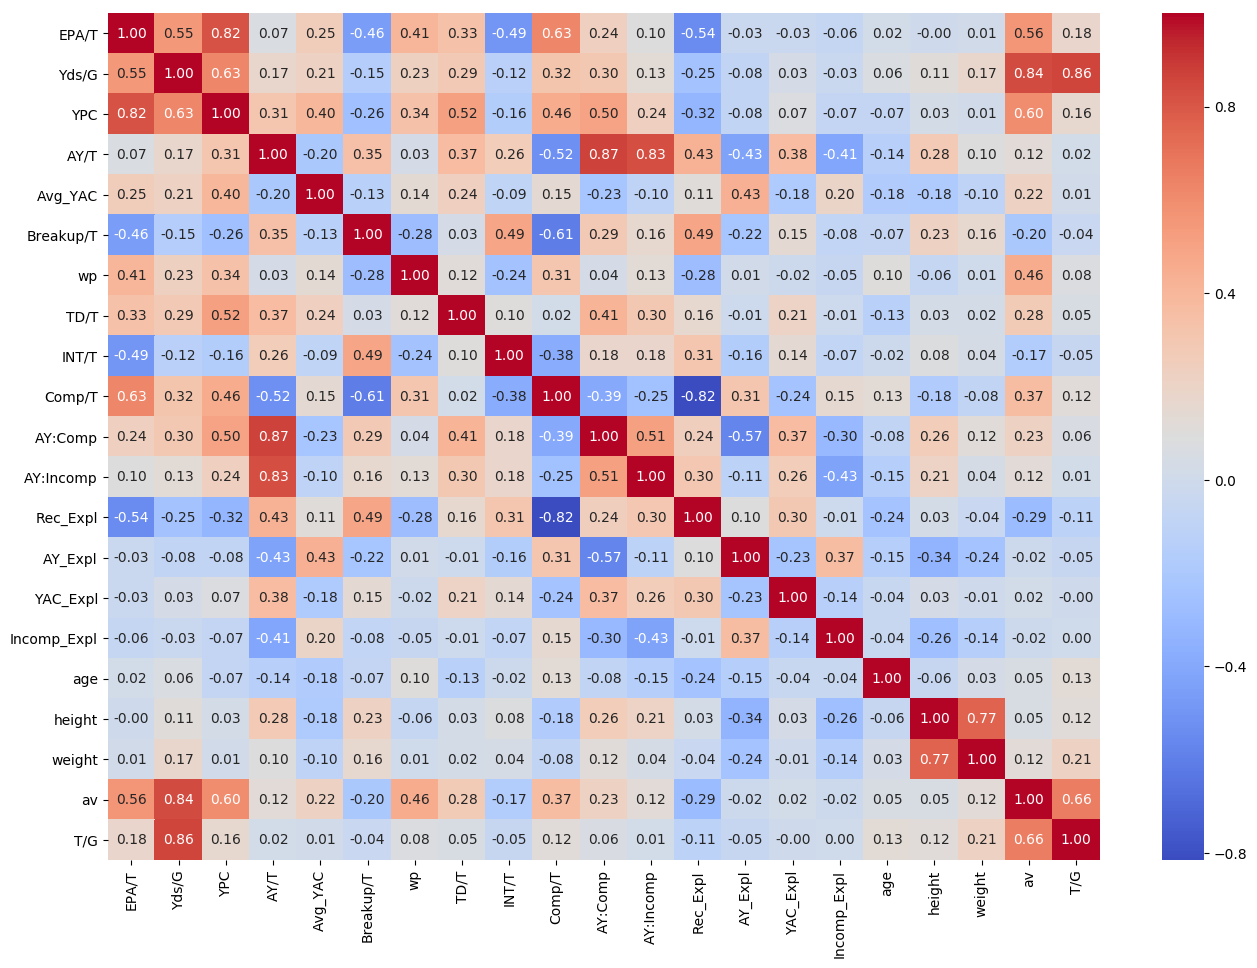

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# change gc column order
print(len(list(gc)))
print(list(gc))
cols = ['id',
        'EPA/T',
        'Yds/G',
        'YPC',
        'AY/T',
        'Avg_YAC',
        'Breakup/T',
         'wp',
         'TD/T',
         'INT/T',
         'Comp/T',
         'AY:Comp',
         'AY:Incomp',
         'Rec_Expl',
         'AY_Expl',
         'YAC_Expl',
         'Incomp_Expl',
         'age',
         'height',
         'weight',
         'av',
         'T/G']
print(list(set(list(gc))-set(cols)))
gc = gc[cols]
print(len(list(gc)))

fig, ax = plt.subplots(figsize=(16, 11))

#saleprice correlation matrix
sns.heatmap(gc.corr(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':10},
            cbar=True,
            square=False)

plt.show()

fig.savefig('./plots/WR_Heatmap.png', bbox_inches='tight')

In [39]:
features = cols[1:]
labels = cols[:1]

# Separating out the features
x = gc.loc[:, features].values
labels = gc.loc[:,labels]


roster_names = roster[['id','age','season','name']]
roster_names = roster_names.drop_duplicates()

labels = pd.merge(how='left',left=labels, right=roster_names, on=['id'])

labels['label'] = labels['season'].astype(str) + '_' + labels['name']

In [40]:
x = gc.loc[:, features].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
pca_wr = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

pca_wr = pd.concat([labels,pca_wr],axis=1)

pca_wr.head(5)

,id,age,season,name,label,pc1,pc2
0,2009ARIA.Boldin,29.0,2009,Anquan Boldin,2009_Anquan Boldin,-1.667209,0.596274
1,2009ARIL.Fitzgerald,26.0,2009,Larry Fitzgerald,2009_Larry Fitzgerald,-0.665442,-1.184231
2,2009ARIS.Breaston,26.0,2009,Steve Breaston,2009_Steve Breaston,-0.757145,0.384501
3,2009ATLM.Jenkins,27.0,2009,Michael Jenkins,2009_Michael Jenkins,1.572576,-1.017283
4,2009ATLR.White,28.0,2009,Roddy White,2009_Roddy White,0.616869,-1.395029


(680,)
(680, 2)


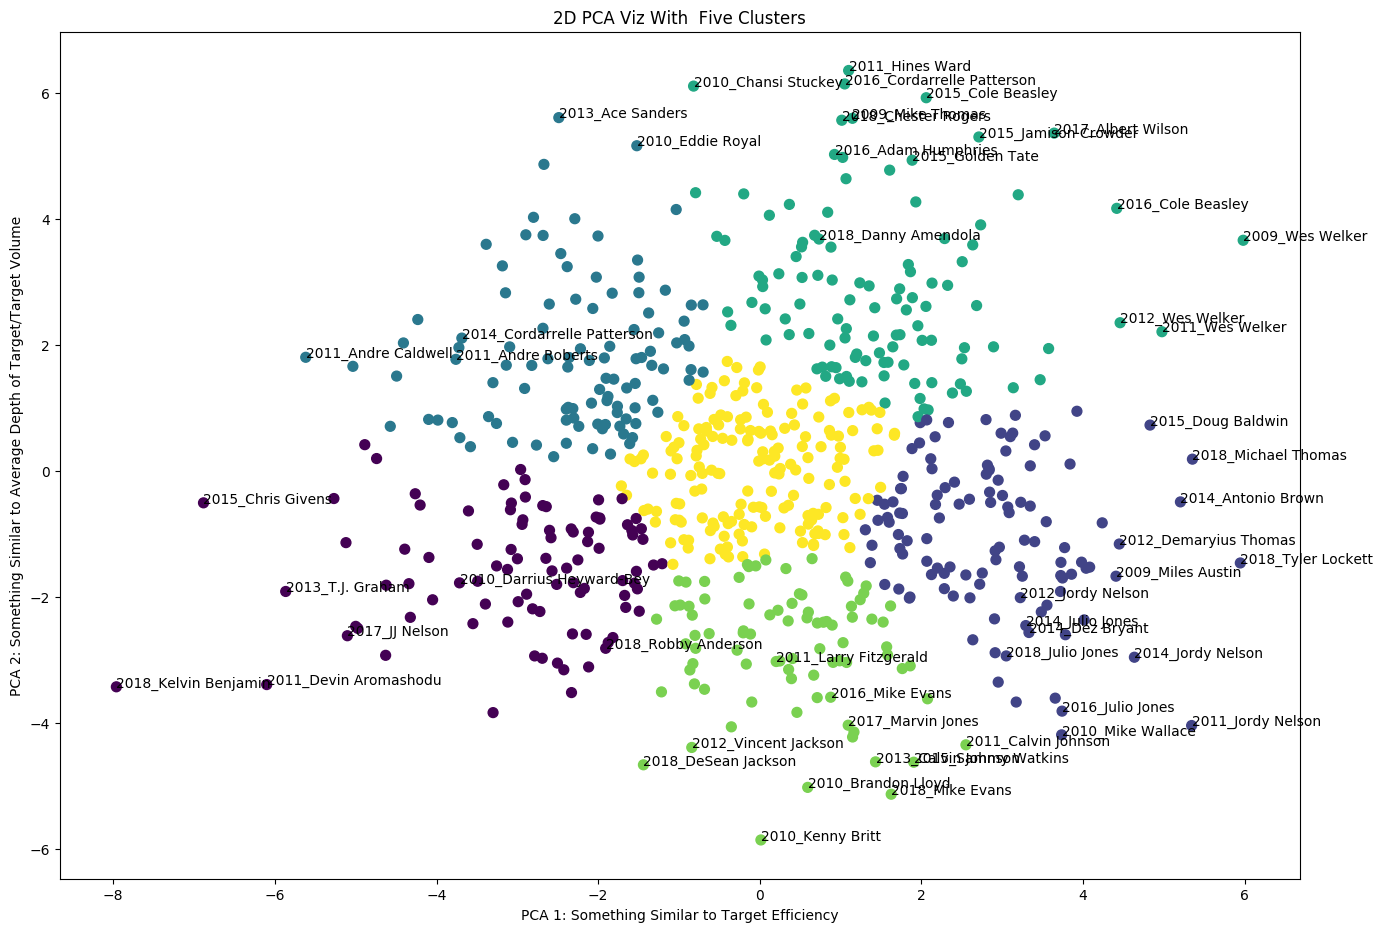

In [74]:
plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots(figsize=(16, 11))

# i like better to be positive
if (pca_wr.loc[pca_wr['label']=='2009_Wes Welker'].pc1.values[0] <1):
    pca_wr['pc1'] = pca_wr['pc1'] * -1

X = pca_wr[['pc1','pc2']].values

x = pca_wr.pc1.values
y = pca_wr.pc2.values
n = pca_wr.label.values

kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
clusters = kmeans.predict(X)
print(clusters.shape)

print(X.shape)
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')

for i, txt in enumerate(n):
    if ((x[i] >= 4.25) | (x[i] <=-5.5)):
        ax.annotate(txt, (x[i], y[i]))
    elif ((y[i] >= 5) | (y[i] <= -4.25)):
        ax.annotate(txt, (x[i], y[i]))
    elif (x[i] >= 3.5):
        if (y[i] <= -3.75):
            ax.annotate(txt, (x[i], y[i]))
    elif (x[i] >= 3):
        if (y[i] <= -2):
            if random.random() > .4:
                ax.annotate(txt, (x[i], y[i]))
    elif ((x[i] >= 3.25) | (x[i] <=-3.5)):
        if random.random() > .9:
            ax.annotate(txt, (x[i], y[i]))
    elif ((y[i] >= 3.25) | (y[i] <= -2.75)):
        if random.random() > .9:
            ax.annotate(txt, (x[i], y[i]))

        
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
pca_wr['cluster'] = clusters

ax.set_title('2D PCA Viz With  Five Clusters')
ax.set_xlabel('PCA 1: Something Similar to Target Efficiency')
ax.set_ylabel('PCA 2: Something Similar to Average Depth of Target/Target Volume')

fig.savefig('./plots/WR_2D.png', bbox_inches='tight')

In [95]:
# rough fantasy estimates
recs['fantasy_points'] = 0.5 * recs['complete_pass'] + 0.1 * recs['yards_gained'] + 6 * recs['touchdown']
ngb1 = recs.groupby(['id'])['fantasy_points'].sum().reset_index()
ngb2 = recs.groupby(['id'])['game_id'].nunique().reset_index()

# fantasy points per game
ngb1 = ngb1.sort_values(by='fantasy_points',ascending=False)
ngb1 = pd.merge(how='left',left=ngb1,right=ngb2, on=['id'])
ngb1['fppg'] = ngb1['fantasy_points']/ngb1['game_id']
ngb1 = ngb1.drop(columns=['fantasy_points','game_id'])

# get std dev of fantasy points
ngb3 = recs.groupby(['id','game_id'])['fantasy_points'].sum().reset_index()
ngb3 = recs.groupby(['id'])['fantasy_points'].std().reset_index()
ngb3 = ngb3.rename(columns={'fantasy_points':'Std_Dev'})
ngb1 = pd.merge(how='left',left=ngb1,right=ngb3, on=['id'])

# cluster -
#0 - Kelvin Benjamin
#1 - navy
#2 - sea blue
#3 - slot receivers
#4 - green
#5 - yellow 


# print(pca_wr.loc[pca_wr['label']=='2013_Ace Sanders'].cluster.values[0])

# add clusters
clusters = pca_wr[['id','cluster']]
ngb1 = pd.merge(how='left',left=ngb1,right=clusters, on=['id'])

cluster_stats = ngb1.groupby(['cluster'])['fppg','Std_Dev'].mean()
cluster_stats

,fppg,Std_Dev
cluster,,
0,6.135694,1.902985
1,11.065385,2.080799
2,4.928675,1.324574
3,7.314458,1.484492
4,10.062953,2.284727
5,7.670749,1.746068
